In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
print(sys.path)
from eigenwell.src import grid, eigen_k, eigen_w
from eigenwell.src.constants import *

print(MU0)
print(EPSILON0)
print(C0)

['/Users/nathanzhao/src/eigenwell/notebooks', '/Users/nathanzhao/src', '/Users/nathanzhao/opt/anaconda3/lib/python38.zip', '/Users/nathanzhao/opt/anaconda3/lib/python3.8', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/lib-dynload', '', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/aeosa', '/Users/nathanzhao/src/ceviche', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions', '/Users/nathanzhao/.ipython']
1.2566370614359173e-06
8.854e-12
299795637.69321626


In [2]:
def sigma_guess(eps_r_guess):  
    neff = np.sqrt(np.max(np.real(eps_r_guess)));
    wvlen = 2*np.pi*C0/omega;
    beta_est = abs(2*np.pi*neff / wvlen);
    sigma = beta_est;
    return sigma;


1e-08 [1.e-08 1.e-06]


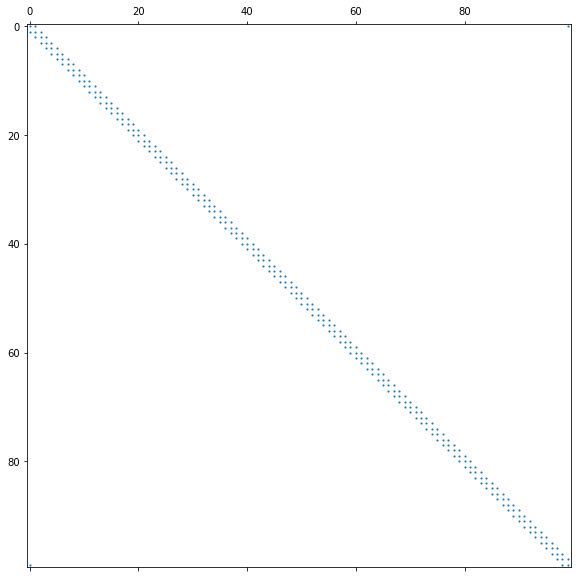

In [10]:
Nx = 100;
N = [Nx,1]
eps_r = np.ones(N)
eps_r[20:80] = 12;
L0 = 1e-6;

x = np.linspace(-1/2, 1/2, Nx)*L0;
a = 1*L0;
wvlen= 5*L0;
#eps_r = 1+np.sin(2*np.pi*x/a);
dx = a/Nx;
dL = np.array([dx,1*L0]);
print(dx, dL)

fd = grid.FiniteDifference(dL,N)

plt.figure(figsize = (10,10))
plt.spy(fd.Dxb@fd.Dxf, markersize = 1);

#print(fd.Dxb@fd.Dxf)


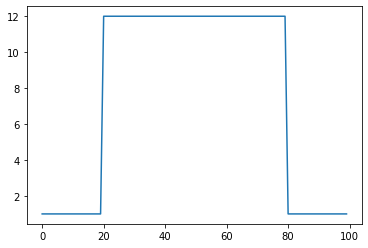

0.37673430918211026 4.9999999999999996e-06 1579136704174.298
(200, 10)


/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


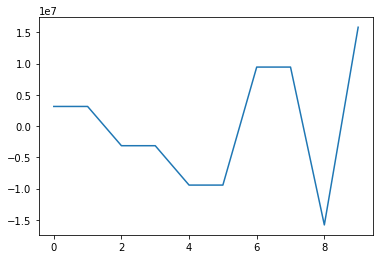

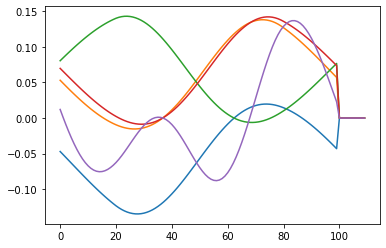

In [12]:
#print(dir(fd))
#print(fd.Dxf)

plt.plot(eps_r)
plt.show();
omega = 2*np.pi*C0/(wvlen)
print(omega/1e15, wvlen, omega**2*MU0*EPSILON0)

solver = eigen_k.EigenK1D(eps_r, fd)

eigvals, eigenvecs = solver.eigensolve(omega)
plt.plot(np.real(eigvals))

print(eigenvecs.shape)

plt.show();
plt.plot(np.real(eigenvecs[0:Nx+10,0:5]))


## Band structure scan

299795637.69321626


/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


(200, 2)


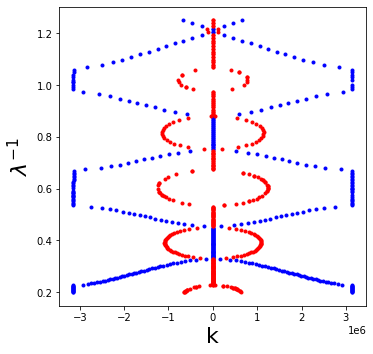

In [5]:
## eigen scan
ni = 200
real_wvlen_scan = np.logspace(np.log10(0.8), np.log10(5), ni);
#real_wvlen_scan = np.linspace(1,10,100)
#print(real_wvlen_scan)
num_modes = 10;
spectra = []
print(C0)
for wvlen in real_wvlen_scan:
    ## modes are a combination of 2
    omega = 2*np.pi*C0/(wvlen*1e-6);
    #print(wvlen, omega/1e15)
    eigenvals, modes = solver.eigensolve(omega, 0, num_modes = 2); 
    #print(modes.shape, eigenvals)
    spectra.append(np.sort(eigenvals));

#     plt.plot(modes);
#     plt.show();
#     break;

spectra = np.array(spectra);
print(spectra.shape)
plt.figure(figsize = (5.5,5.5));
spectra = np.array(spectra);
plt.plot(np.real(spectra[:,:]), 1/real_wvlen_scan, '.b')
plt.plot(np.imag(spectra[:,:]), 1/real_wvlen_scan, '.r')
plt.xlabel('k', fontsize = 22)
plt.ylabel('$\lambda^{-1}$', fontsize = 22)
plt.show();

In [6]:
print()

In [7]:
## full code
def eigen1D_Efield(wvlen, eps_r, dx, num_modes=10):
    '''
    :param wvlen:
    :param eps_r:
    :param a:
    :param dx:
    :return:
    '''
    L0 = 1e-6;
    eps0 = 8.854e-12 *L0;
    mu0 = 4 * np.pi * 1e-7*L0;
    c0 = 1/np.sqrt(eps0*mu0)

    omega = 2 * np.pi * c0 / wvlen ;

    Nx = len(eps_r);
    dL = dx;
    Dxf = createDws('x', 'f', [dL,1], [Nx,1], matrix_format=matrix_format);
    Dxb = createDws('x', 'b', [dL,1], [Nx,1], matrix_format=matrix_format);
    #Epxx = grid_average(eps_r, 'x');
    #Tepxx = sp.spdiags(Epxx, 0, Nx, Nx, format=matrix_format)
    invTepzz = sp.spdiags(1 /(eps_r), 0, Nx, Nx, format=matrix_format)
    I = sp.identity(Nx, format = matrix_format);

    M = invTepzz;
    C = -invTepzz@(-1j * (Dxf + Dxb));
    K = -invTepzz@(Dxf@Dxb) - omega**2*mu0*eps0*I;

    OB = sp.bmat([[M,None],[None, I]], format = matrix_format);
    OA = sp.bmat([[C,K],[-I, None]], format = matrix_format);

    #print(np.linalg.cond(OA.todense())), conditioning is 10000, which is not amazing...
    #print(type(OB), type(OA))
    # get guess

    neff = np.sqrt(np.max(np.real(eps_r)));
    beta_est = abs(2*np.pi*neff / wvlen);
    sigma = beta_est;
    D = bslash(OB, OA);
    # plt.imshow(np.real(OA.toarray()))
    # plt.show();
    eigenvals, eigenmodes = sp.linalg.eigs(D, k=num_modes, sigma = 0)

    return eigenvals, eigenmodes;

## using eigenomega (k) is not resolved
In fact, k is implicitly 0?

In [8]:
def grid_average(center_array, w):
    '''
        center_array, 1d eps_r
    '''
    # computes values at cell edges

    xy = {'x': 0, 'y': 1}
    center_shifted = np.roll(center_array, 1, axis=xy[w])
    avg_array = (center_shifted+center_array)/2
    return avg_array

print(eps_r.shape)
print(grid_average(eps_r, 'x').shape)

(100, 1)
(100, 1)


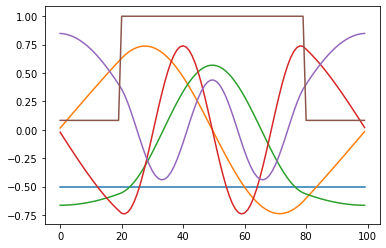

[1.69588673e+17+0.j 3.85149504e+29+0.j 7.28113105e+29+0.j
 2.00773746e+30+0.j 2.75385034e+30+0.j 5.12640937e+30+0.j
 5.27629910e+30+0.j 8.36570152e+30+0.j 9.67231200e+30+0.j
 1.34253047e+31+0.j]


/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


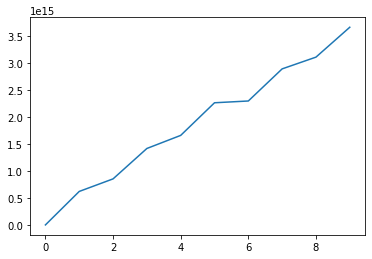

In [9]:
import scipy.sparse as sp
solver = eigen_w.EigenOmega1D(eps_r, fd)
#print(solver.A)

#eigenvals, eigenvecs = sp.linalg.eigs(solver.A, k=10, which = 'SM')

eigenvals, eigenvecs = solver.eigensolve(num_modes = 10)
plt.plot(np.real(eigenvecs[:,0:5])/0.2)
plt.plot(eps_r/12)
plt.show();

print(eigenvals)
plt.plot(np.sqrt(eigenvals))